# Choosing Sample Sizes and Estimators in Studies of Online Behavior
J. Nathan Matias ([natematias.com](https://natematias.com)) ([@natematias](https://twitter.com/natematias))
January 7, 2019

In my roles at Princeton University and CivilServant, I often conduct and teach students how to conduct power analyses of experiments. In this process, researchers state their assumptions about a study and what they want to be able to observe and work from those assumptions to make decisions about the study based on what is statistically-possible:
* deciding between different kinds of designs (what to measure, how many arms, comparisons, etc)
* deciding between different kinds of estimators
* deciding what sample size to use

In September 2018, I wrote a blog post about [estimating counts of events in behavioral product testing](https://medium.com/@natematias/estimating-counts-of-events-in-behavioral-product-testing-e3b68f6143e2). Since then, I have learned how to use [DeclareDesign](http://declaredesign.org/), software for designing and evaluating study designs, including power analyses. This followup notebook continues what I began in that post, by more systematically comparing linear, poisson, and negative binomial estimators using simulated parameters based on  a real study I conducted in 2016.

I focused on these estimators because studies of online behavior usually include count outcomes with a very specific characteristic that incidents are not independent: things that receive a higher count of incidents tend to attract even more incidents. For example, a Facebook post with more likes will be seen by more people and have a higher rate of likes than a post with fewer likes. We see this pattern with likes, retweets, the number of comments in a discussion, the number of donations to a charitable activity, and many other online phenomena.

This example will exclusively focus on count outcomes. Mathematics in the utility functions are drawn from:
*  Long, J. Scott. 1997. [Regression Models for Categorical and Limited Dependent Variables](https://us.sagepub.com/en-us/nam/regression-models-for-categorical-and-limited-dependent-variables/book6071). 1 edition. Thousand Oaks: SAGE Publications, Inc.

I am grateful to my fellow postdoc [Jasper Cooper](http://jasper-cooper.com/) for presenting to the Paluck Lab last fall about how to use DeclareDesign, and to Neal Fultz, for [generously answering my questions on the DeclareDesign forum](http://discuss.declaredesign.org/t/subsetting-errors-in-a-glm-nb-multi-arm-experiment/60).

In [334]:
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)
library(ggplot2)
library(rlang)
library(tidyverse)
library(viridis)
library(DeclareDesign)
## Installed DeclareDesign 0.13 using the following command:
# install.packages("DeclareDesign", dependencies = TRUE,
#                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] viridis_0.5.1        viridisLite_0.3.0    DeclareDesign_0.12.0
 [4] estimatr_0.14        fabricatr_0.6.0      randomizr_0.16.1    
 [7] forcats_0.3.0        stringr_1.3.1        purrr_0.2.5         
[10] readr_1.2.1          tidyr_0.8.2          tibble_1.4.2        
[13] tidyverse_1.2.1      rla

### Utility Methods

In [28]:
# Return the difference in mu associated with an incidence rate ratio
# from a negative binomial model. This difference can then be used to
# simulate a negative binomial distribution for the effect of a given irr
#                                                                       
#` @param mu The baseline mu in question                               
#` @param irr The incidence rate ratio in question
mu.diff.from.mu.irr <- function(mu, irr){
    mu*(irr-1)
}

# Return the total sum of betas for a
# logistic regression, given a probability
#
#` @param p the probability in question
betas.logit.from.prob <- function(p){
    log(p/(1-p))
}


# Return the total sum of betas for a
# logistic regression, given a probability
#
#` @param Y list of observed Ys
betas.logit.from.mean <- function(Y){
    p = mean(Y)
    log(p/(1-p))
}

# Return the minimum power reported in a diagnosis
# 
#` @param diagnosis
min.diagnosis.power <- function(diagnosis){
    min(diagnosis$diagnosands_df['power'])
}


## Example DeclareDesign definition
To diagnose a design with DeclareDesign, declare the basic assumptions about the study:
* simulating everything: 
 * a population
 * covariates
 * every potential outcome for every observation
 * assignment
 * estimands - what people sometimes describe as the expected "true effects"
 * "reveal step" simulates data collection, along with assumptions about incompleteness in data collection
 * estimators (the statistical tests you're using in the final estimation of results)
 
 Process
 * for one iteration of a power analysis:
     * create an experiment design object / simulation
     * diagnose the experiment design object
 * for a whole power analysis
     * create a bunch of designs at different sample sizes, etc
     * compare the diagnoses between them

### Define study assumptions
In this code example, I define some of the assumptions about the study in a dataframe that can then be adjusted and iterated as part of a power analysis. This is not required by DeclareDesign.

I have derived the mu and theta parameters for this simulation by using the [`fitdistr`](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/fitdistr.html) method in the `MASS` R library.

In [310]:
example.config <- data.frame(
    pa.label = "example.design",
    n.max = 6000,
    n.min = 200,
    
    YA.mu    = 7.680505605,
    YA.theta = 0.095880936,
    YA.effect.irr = exp(0.335)
)

In [302]:
design <-   declare_population(
                N = 500) +
            declare_potential_outcomes(
                YA_Z_0 = rnegbin(n=N, mu = example.config$YA.mu, 
                                 theta = example.config$YA.theta),
                YA_Z_1 = rnegbin(n=N, mu =  mu.diff.from.mu.irr(
                                                example.config$YA.mu,
                                                example.config$YA.effect.irr),
                                 theta = example.config$YA.theta)
            ) +
            declare_assignment(num_arms = 2,
                               conditions = (c("0", "1"))) +
            declare_estimand(ate_YA_1_0  = log(example.config$YA.effect.irr)) +
            declare_reveal(outcome_variables = c("YA"))  +
            declare_estimator(handler=tidy_estimator(function(data){
                              m <- lm(formula=log1p(YA) ~ Z, data)
                              out <- subset(tidy(m), term == "Z1")
                              transform(out,
                                  conf.low = estimate - 1.96*std.error,
                                  conf.high = estimate + 1.96*std.error
                              )
                              }), estimand="ate_YA_1_0", label="YA.lm.log 1/0") +
            declare_estimator(handler=tidy_estimator(function(data){
                              m <- glm.nb(formula=YA ~ Z, data)
                              out <- subset(tidy(m), term == "Z1")
                              transform(out,
                                  conf.low = estimate - 1.96*std.error,
                                  conf.high = estimate + 1.96*std.error
                              )
                              }), estimand="ate_YA_1_0", label="YA.nb 1/0") +
            declare_estimator(handler=tidy_estimator(function(data){
                              m <- glm(formula=YA ~ Z, family = "poisson", data)
                              out <- subset(tidy(m), term == "Z1")
                              transform(out,
                                  conf.low = estimate - 1.96*std.error,
                                  conf.high = estimate + 1.96*std.error
                              )
                              }), estimand="ate_YA_1_0", label="YA.pois 1/0")

### View Design Details
DeclareDesign makes it possible to view a detailed log of the assumptions built into a specific research design, as well as the values generated by a single simulation of those assumptions. Here is an example:

In [303]:
design


Design Summary

Step 1 (population): declare_population(N = 500) -------------------------------

N = 500 

Added variable: ID 
 N_missing N_unique     class
         0      500 character

Step 2 (potential outcomes): declare_potential_outcomes(YA_Z_0 = rnegbin(n = N, mu = example.config$YA.mu,     theta = example.config$YA.theta), YA_Z_1 = rnegbin(n = N,     mu = mu.diff.from.mu.irr(example.config$YA.mu, example.config$YA.effect.irr),     theta = example.config$YA.theta)) 

Added variable: YA_Z_0 
 min median mean max    sd N_missing N_unique
   0      0 6.76 181 19.46         0       56

Added variable: YA_Z_1 
 min median mean max   sd N_missing N_unique
   0      0 2.77 116 9.66         0       35

Step 3 (assignment): declare_assignment(num_arms = 2, conditions = (c("0", "1"))) 

Added variable: Z 
    0    1
  250  250
 0.50 0.50

Added variable: Z_cond_prob 
  0.5
  500
 1.00

Step 4 (estimand): declare_estimand(ate_YA_1_0 = log(example.config$YA.effect.irr)) 

A single draw of

### Diagnose Design
In DeclareDesign, the diagnosis step simulates the study a large number of times and generates diagnosis information for the research design.

In [304]:
diagnose_design(design, sims=500, bootstrap_sims=500)


Research design diagnosis based on 500 simulations. Diagnosand estimates with bootstrapped standard errors in parentheses (500 replicates).

 Design Label Estimand Label Estimator Label Term N Sims   Bias   RMSE  Power
       design     ate_YA_1_0   YA.lm.log 1/0   Z1    500  -0.59   0.60   0.66
                                                         (0.00) (0.00) (0.02)
       design     ate_YA_1_0       YA.nb 1/0   Z1    500  -1.24   1.27   0.89
                                                         (0.01) (0.01) (0.01)
       design     ate_YA_1_0     YA.pois 1/0   Z1    500  -1.24   1.27   1.00
                                                         (0.01) (0.01) (0.00)
 Coverage Mean Estimate SD Estimate Mean Se Type S Rate Mean Estimand
     0.00         -0.25        0.10    0.10        1.00          0.33
   (0.00)        (0.00)      (0.00)  (0.00)      (0.00)        (0.00)
     0.01         -0.90        0.28    0.29        1.00          0.33
   (0.00)        (0.01)      (0.

### Interpreting the diagnosis
DeclareDesign provides us with many very usful pieces of information for evaluating a given research design. Here are four that are especially useful:
* **Power**: The statistical power of the overall study design. As used here, power is the probability that the result from a given study will satisfy the decision rule (in this case, a statistically-significant result at alpha = 0.05)
* **Bias**: This result provides the average difference, across simulations, between the estimand (simulated "true effect") and the outcome of the estimation procedure. If a research procedure (including the estimator) is systematically biased within the parameters of the simulation, this result can show what that bias is. Like any simulation, the estimate of bias is more accurate at higher numbers of simulations
* **Coverage**: The probability that the estimand is included in the confidence intervals of the estimated result. This is especially useful when making decisions about the estimation procedure of a study
* **RMSE**: The root mean square error is the standard deviation of the difference between the estimator and the estimand across simulations. When comparing two estimators, a smaller root mean square error is better sqrt(mean((estimate - estimand)^2))


# Diagnose Designs by Iterating and Searching for Statistical Power

The following methods are used to diagnose the experiment defined in `diagnose.experiment`:
* searching for the **sample size** with an 80% chance of observing a statistically-significant effect, for different estimators
* evaluating the **bias** of each estimator- how systematically wrong is the estimate?
* evaluating the **coverage** of each estimator- the chance that the estimand is contained within the confidence intervals of the estimate
* evaluating the **type s error rate** the chance that the estimate is actually the opposite sign from the estimand- which is pretty much the worst possible outcome

In [305]:
# CONSTRUCT A DIAGNOSIS
#
#' @param n.size     the sample size to test
#' @param config.df  the configuration dataframe to use 
#' @param sims.count the number of simulations to carry out
#' @param bootstrap.sims.count the number of bootstraps for estimating the simulation test statistics  

diagnose.experiment <- function(n.size, config.df, sims.count=500, bootstrap.sims.count=500){
    design <- declare_population(
                N = n.size) +
            declare_potential_outcomes(
                YA_Z_0 = rnegbin(n=N, mu = config.df$YA.mu, 
                                 theta = config.df$YA.theta),
                YA_Z_1 = rnegbin(n=N, mu =  config.df$YA.mu + mu.diff.from.mu.irr(
                                                config.df$YA.mu,
                                                config.df$YA.effect.irr),
                                 theta = config.df$YA.theta)
            ) +
            declare_assignment(num_arms = 2,
                               conditions = (c("0", "1"))) +
            declare_estimand(ate_YA_1_0  = log(example.config$YA.effect.irr)) +
            declare_reveal(outcome_variables = c("YA"))  +
            declare_estimator(handler=tidy_estimator(function(data){
                              m <- lm(formula=log1p(YA) ~ Z, data)
                              out <- subset(tidy(m), term == "Z1")
                              transform(out,
                                  conf.low = estimate - 1.96*std.error,
                                  conf.high = estimate + 1.96*std.error
                              )
                              }), estimand="ate_YA_1_0", label="YA.lm.log 1/0") +
            declare_estimator(handler=tidy_estimator(function(data){
                              m <- glm.nb(formula=YA ~ Z, data)
                              out <- subset(tidy(m), term == "Z1")
                              transform(out,
                                  conf.low = estimate - 1.96*std.error,
                                  conf.high = estimate + 1.96*std.error
                              )
                              }), estimand="ate_YA_1_0", label="YA.nb 1/0") +
            declare_estimator(handler=tidy_estimator(function(data){
                              m <- glm(formula=YA ~ Z, family = "poisson", data)
                              out <- subset(tidy(m), term == "Z1")
                              transform(out,
                                  conf.low = estimate - 1.96*std.error,
                                  conf.high = estimate + 1.96*std.error
                              )
                              }), estimand="ate_YA_1_0", label="YA.pois 1/0")
    
    diagnosis <- diagnose_design(design, sims = sims.count, 
                                 bootstrap_sims = bootstrap.sims.count)
    diagnosis
}

In [306]:
# Conduct a binary search for a certain level of statistical power
# within the constraints of a configuration file
#
#` @param config.df The configuration file in question
#` @diagnosis.method The method that conducts a single DeclareDesign diagnosis and returns the diagnosis
#` @target.power The statistical power that ideally should be the minimum across the study
#` @target.tolerance How close to the desired statistical power is close enough?
#` @min.sample.diff If the search is close enough that the change is less than min.sample.diff, end the search
#` @start.sample.size if specified, use the starting value as the initial sample size to use

search.for.power <- function(config.df, diagnosis.method = diagnose.experiment, 
                             target.power = 0.85, target.tolerance = 0.01, 
                             min.sample.diff = 100,
                             start.sample.size = NA){  
    max.sample.size = config.df$n.max
    min.sample.size = config.df$n.min
    if(is.na(start.sample.size)){
        current.sample.size = as.integer(max.sample.size / 2)
    }else{
        current.sample.size = start.sample.size
    }
    current.power = 0.0

    ## Initialize first iteration
    print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
    flush.console()

    ptm = proc.time() #record time the simulation started
    ddf <- diagnosis.method(current.sample.size, config.df)
    ddf$diagnosands$n <- current.sample.size
    diagnoses.df = ddf$diagnosands
    current.power <- min.diagnosis.power(ddf)

    ## output elapsed time for this iteration
    time.elapsed <- proc.time() -  ptm
    print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))

    
    if(current.power < target.power){
        min.sample.size = current.sample.size
        print(paste(current.power, "<", target.power))
    }else{
        max.sample.size = current.sample.size
        print(paste(current.power, ">", target.power))
    }

    current.sample.size = min.sample.size + as.integer((max.sample.size - min.sample.size)/2)
    while(all.equal(target.power, current.power, tolerance = target.tolerance)!=TRUE){
        print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
        flush.console()

        ptm = proc.time() #record time the simulation started

        ## conduct simulations
        ddf <- diagnosis.method(current.sample.size, config.df)
        ddf$diagnosands$n <- current.sample.size
        ## append simulation results to dataframe
        diagnoses.df <- rbind(diagnoses.df, ddf$diagnosands)
        
        ## output elapsed time for this iteration
        time.elapsed <- proc.time() -  ptm
        print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))


        ## check the current statistical power and
        ## carry out the binary search by first updating the boundaries
        current.power <- min.diagnosis.power(ddf)
        if(current.power < target.power){
            min.sample.size = current.sample.size
            print(paste(current.power, "<", target.power))
        }else{
            max.sample.size = current.sample.size
            print(paste(current.power, ">", target.power))
        }
        ## update the current pointer, or break if
        ## the sample size difference is less than or equal
        ## to ten
        sample.size.diff <- as.integer((max.sample.size - min.sample.size)/2)
        if(abs(sample.size.diff) <= min.sample.diff){
            print(paste("Sample size difference ", abs(sample.size.diff), 
                        " <= ", min.sample.diff, ". Ending cycle.", sep=""))
            break
        }
        current.sample.size = min.sample.size + sample.size.diff
    }
    diagnoses.df
}

In [307]:
# Iterate linearly for a certain level of statistical power
# within the constraints of a configuration file
# at a certain sample size increment. Useful for
# illustrating ideas, or for comparing estimators with
# very different statistical power, where the binary search
# will optimize for the worst estimator but not show useful
# indormation about more efficient estimators
#
#` @param config.df The configuration file in question
#` @diagnosis.method The method that conducts a single DeclareDesign diagnosis and returns the diagnosis
#` @iteration.interval when iterating, use this interval between sample sizes

iterate.for.power <- function(config.df, diagnosis.method = diagnose.experiment, 
                             iteration.interval){  
    max.sample.size = config.df$n.max
    min.sample.size = config.df$n.min
    current.sample.size = min.sample.size
    
    iteration.count = ceiling((max.sample.size - min.sample.size) / iteration.interval)

    ## Initialize first iteration
    print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
    flush.console()

    ptm = proc.time()
    ddf <- diagnosis.method(current.sample.size, config.df)
    ddf$diagnosands$n <- current.sample.size
    diagnoses.df = ddf$diagnosands
    current.power <- min.diagnosis.power(ddf)
    time.elapsed <- proc.time() -  ptm
    print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))
    
    for(i in seq(1, iteration.count)){
        current.sample.size = current.sample.size + iteration.interval
        print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
        flush.console()
    
        ptm = proc.time()
        ## conduct simulations
        ddf <- diagnosis.method(current.sample.size, config.df)
        ddf$diagnosands$n <- current.sample.size
        ## append simulation results to dataframe
        diagnoses.df <- rbind(diagnoses.df, ddf$diagnosands)
        time.elapsed <- proc.time() -  ptm
        print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))
    }
    diagnoses.df
}

In [308]:
# Create a plot of a power search or iteration output
# Especially useful in cases with multiple DVs or models
#
#' @param diagnoses Dataframe of diagnosis info
#` @param config.df the power analysis config dataframe

plot.power.results <- function(diagnoses, config.df){
    for(estimator_label in unique(diagnoses$estimator_label)){
        estimator.diagnoses <- diagnoses[diagnoses$estimator_label==estimator_label,]
        estimator_min_sample = min(estimator.diagnoses$n[estimator.diagnoses$power>0.8])
        p <- ggplot(data=estimator.diagnoses, aes(n, power)) +
                geom_point(color="coral") +
                xlab("sample size") +
                ylim(0,1) +
                geom_hline(aes(yintercept=0.8), linetype="dashed") +
                theme_light() +
                ggtitle(paste(config.df$pa.label, ": statistical Power for Estimator ", estimator_label, "\n",
                              "Minimum sample: ", estimator_min_sample, sep="")) +
                ggsave(paste("figures/power.analysis.", make.names(estimator_label), ".", config.df$pa.label, ".png", sep=""))
    }
}

### Conduct Iteratitive and Binary Searches for Statistical Power

In [311]:
power.iterate.df <- iterate.for.power(example.config, iteration.interval = 200)

[1] "min: 200 max: 6000 current: 200"
[1] "     seconds: 18"
[1] "min: 200 max: 6000 current: 400"
[1] "     seconds: 21"
[1] "min: 200 max: 6000 current: 600"
[1] "     seconds: 22"
[1] "min: 200 max: 6000 current: 800"
[1] "     seconds: 26"
[1] "min: 200 max: 6000 current: 1000"
[1] "     seconds: 28"
[1] "min: 200 max: 6000 current: 1200"
[1] "     seconds: 31"
[1] "min: 200 max: 6000 current: 1400"
[1] "     seconds: 33"
[1] "min: 200 max: 6000 current: 1600"
[1] "     seconds: 36"
[1] "min: 200 max: 6000 current: 1800"
[1] "     seconds: 39"
[1] "min: 200 max: 6000 current: 2000"
[1] "     seconds: 42"
[1] "min: 200 max: 6000 current: 2200"
[1] "     seconds: 45"
[1] "min: 200 max: 6000 current: 2400"
[1] "     seconds: 48"
[1] "min: 200 max: 6000 current: 2600"
[1] "     seconds: 51"
[1] "min: 200 max: 6000 current: 2800"
[1] "     seconds: 54"
[1] "min: 200 max: 6000 current: 3000"
[1] "     seconds: 57"
[1] "min: 200 max: 6000 current: 3200"
[1] "     seconds: 60"
[1] "min: 20

In [330]:
power.search.df <- search.for.power(example.config, min.sample.diff = 100)

[1] "min: 200 max: 6000 current: 3000"
[1] "     seconds: 58"
[1] "0.584 < 0.85"
[1] "min: 3000 max: 6000 current: 4500"
[1] "     seconds: 81"
[1] "0.708 < 0.85"
[1] "min: 4500 max: 6000 current: 5250"
[1] "     seconds: 95"
[1] "0.77 < 0.85"
[1] "min: 5250 max: 6000 current: 5625"
[1] "     seconds: 101"
[1] "0.828 < 0.85"
[1] "min: 5625 max: 6000 current: 5812"
[1] "     seconds: 106"
[1] "0.866 > 0.85"
[1] "Sample size difference 93 <= 100. Ending cycle."


### Plotting the Results of Experiment Diagnoses

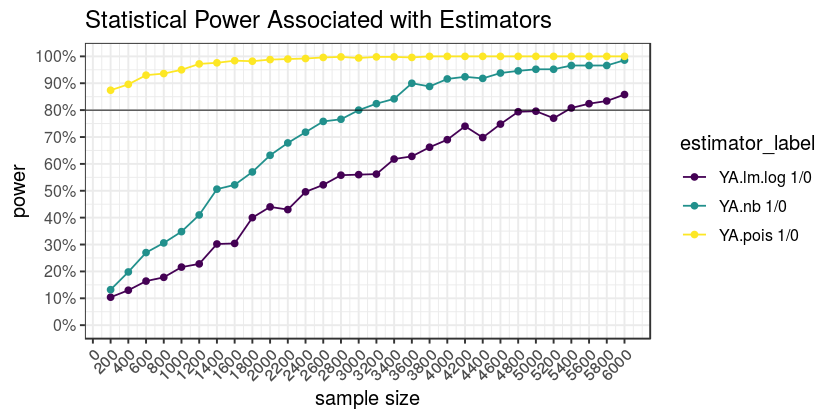

In [325]:
ggplot(power.iterate.df, aes(n, power, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    geom_hline(yintercept=0.8, size=0.25) +
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_x_continuous(breaks = seq(000,6000,200)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Statistical Power Associated with Estimators")

As you can see in the above example, each estimation approach has a very different relationship between sample size and the chance of observing a statistically-significant effect. The log-transformed linear regression model (YA.lm.log) requires the largest sample sizes, while the poisson model requires the smallest sample sizes.

Statistical significance is not a helpful measure of the appropriateness of a model, and models with low p values can be confidently wrong. That's why it's important to example **bias**, **coverage**, and **type s errors**.

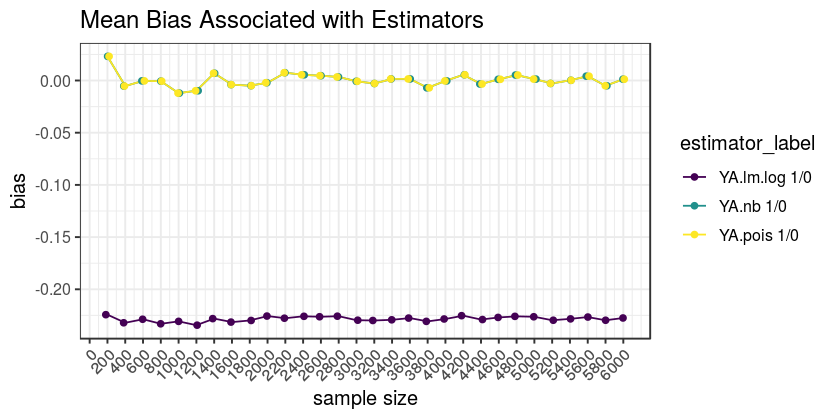

In [326]:
ggplot(power.iterate.df, aes(n, bias, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_jitter(width=20, height=0) +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(000,6000,200)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Mean Bias Associated with Estimators")

On average, the negative binomial and poisson models have a bias of almost zero, while the log-transformed linear regression substantially under-estimates the effect size. Not only does the linear regression model require a larger sample, but the result is systematically low.

One should never evaluate the accuracy of a model based on the average bias over many experiments, since it's possible that individual estimates could still be very wrong. The **Type S error rate** and **coverage** provide a picture of how often those estimates are wrong.

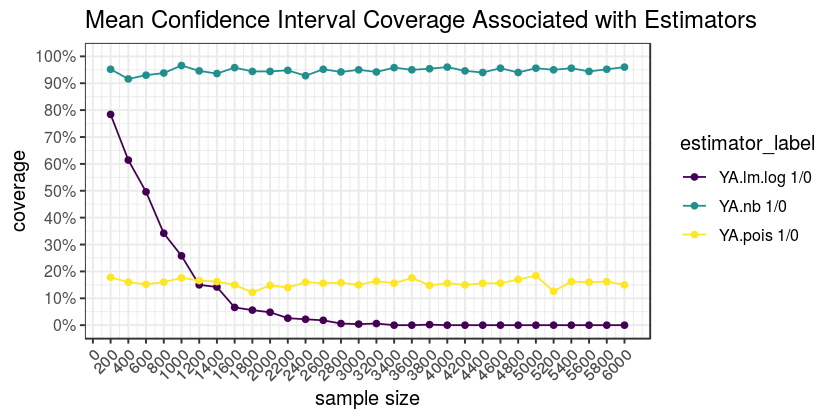

In [327]:
ggplot(power.iterate.df, aes(n, coverage, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(000,6000,200)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Mean Confidence Interval Coverage Associated with Estimators")

The coverage measure provides an estimate of how often the estimand (the true effect) is contained within the 95% confidence intervals of the model. Even though the poisson and negative binomial models have identically-low bias, the estimand is reliably within the 95% confidence intervals of the poisson model less than 20% of the time. Because the linear model is systematically biased, the coverage of the estimator declines with larger sample sizes as the estimate becomes more precise. For both of these models, the 95% confidence interval is a false hope, since the estimand is *not* within those intervals 95% of the time.

Compared to these two models, the 95% confidence intervals of the **negative binomial model** consistently include the estimand about 95% of the time.

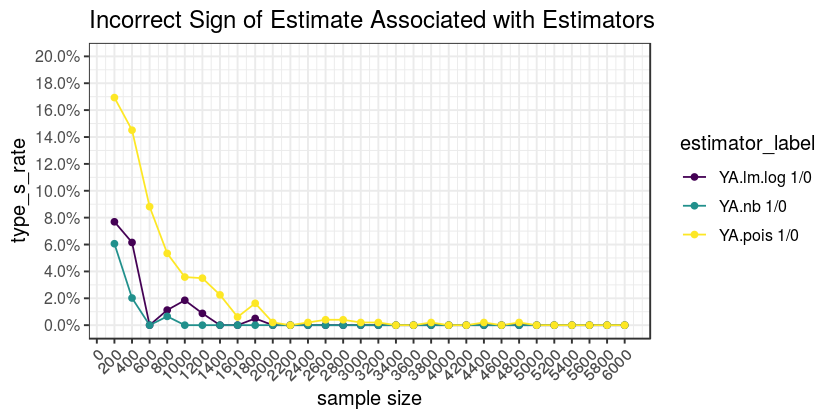

In [328]:
ggplot(power.iterate.df, aes(n, type_s_rate, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(000,6000,200)) +
    scale_y_continuous(breaks = seq(0,0.2,0.02), limits = c(0,0.2), labels=scales::percent) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Incorrect Sign of Estimate Associated with Estimators")

For effect sizes near 0, inaccurate estimates can produce **type S errors**, where the estimated effect is actually the *opposite* from the estimand. Type S errors are very dangerous if the results are being used to guide decisions, especially if the dependent variable is not reversible. Guided by a type S error, a decision-maker might choose an action that actually makes the situation worse, under the beliefe that it will become better.

At very small sample sizes, all of the estimators produce some type S errors. But the poisson model performs very badly, with nearly 17% of experiments producing a result with the incorrect sign at sample sizes where most results are statistically-significant. In contrast, the linear and negative binomial models have an estimated type S error rate of zero at sample sizes large enough to result in statistically-significant results 80% of the time or more. 

The clear winner in this simulated comparison is the **negative binomial model**, which minimizes bias, has a low type S error rate, has high coverage, and minimizes sample size.

### Plotting the Results of a Binary Search for Statistical Power
While the linear, iterative power analysis clearly illustrated the differences between the models, each of the ~30 simulated sample sizes took 18 to 109 seconds, roughly 30 minutes. That's because the maximum likelihood methods used by the negative binomial and poisson models also iterate through a large number of tests. More complex experiments using these models have sometimes taken me days to estimate.

Power analyses can be sped up by using basic methods from computer science. For example, a **binary search** algorithm can find the desired statistical power with a much smaller number of iterations:
* linear search (`iterate.for.power`) will always carry out N iterations where N is max-min/iteration.size
* [binary search](https://en.wikipedia.org/wiki/Binary_search_algorithm)  (`search.for.power`) will find the desired statistical power in log(N) time, which could save hours or even days from a power analysis
    * Binary search is possible because we expect there to be a continuously increasing relationship between the sample size and statistical power
    
In this case, the linear search tested ~30 sample sizes, while the binary search only tested 6. Here is the output of the binary search:

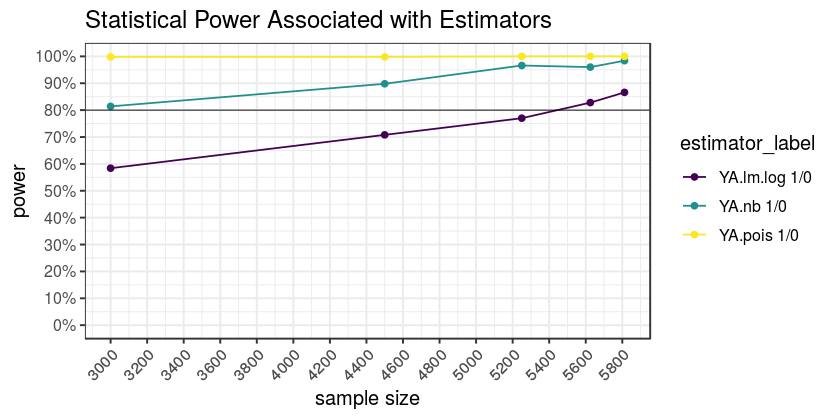

In [331]:
ggplot(power.search.df, aes(n, power, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    geom_hline(yintercept=0.8, size=0.25) +
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_x_continuous(breaks = seq(000,6000,200)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Statistical Power Associated with Estimators")

# Where to Learn More

This example is a continuation of my blog post on  [estimating counts of events in behavioral product testing](https://medium.com/@natematias/estimating-counts-of-events-in-behavioral-product-testing-e3b68f6143e2) and is an example for my Princeton class [SOC412: Designing Field Experiments at Scale](https://natematias.com/courses/soc412/). 

I am also publishing this to answer questions that I sometimes have from reviewers about why I choose to use negative binomial models when estimating effects on counts of online behavior.

If you want to learn more about the topics in this Jupyter notebook, I suggest the following resources:
* [DeclareDesign](https://declaredesign.org/) has helpful documentation and a [wonderfully-supportive discussion forum](http://discuss.declaredesign.org/).
* For more on count models, I suggest: 
    * Long, J. Scott. 1997. [Regression Models for Categorical and Limited Dependent Variables](https://us.sagepub.com/en-us/nam/regression-models-for-categorical-and-limited-dependent-variables/book6071). 1 edition. Thousand Oaks: SAGE Publications, Inc.

# You are Free to Copy & Reuse this Code 

Copyright 2019 J. Nathan Matias

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.